In [301]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump

import xml.etree.ElementTree as ET

import requests

import re
import time
from time import time

This map reads in data on (from the Data folder):
 
Area data
1. Lower super output areas (lsoas) and the index of multiple deprivation and population data
2. Ward area data of Liverpool and associated data

Points data
3. Food outlets data
4. The affordable and emergency food outlet data


and processes it:
    
- Takes the area data for lsoas and ward, converts to geojson and ranks it into quintiles
- Outputs a Liverpool border geojson
- Geocodes the points data and outputs as geojson




In [302]:
# Function to extract ward boundaries from API
URL = "http://statistics.data.gov.uk/resource.json?uri=http%3A%2F%2Fstatistics.data.gov.uk%2Fid%2Fstatistical-geography%2F{code}%2Fgeometry"

# Function to call the API with the geography codes and return the shape files using the API
def get_shape(gss_code):
    return requests.get(URL.format(code=gss_code)).json()

# Area data: Reads in the index of multiple deprivation data at Lower Super output Areas (LSOAs) adds geographies quintiles variables and write out as csv

In [303]:
#Reads in the spreadsheet of the index of multiple deprivation
#index_mult_dep = pd.read_excel('Data/File_8_-_IoD2019_Underlying_Indicators.xlsx')

index_mult_dep=pd.ExcelFile('Data/File_8_-_IoD2019_Underlying_Indicators.xlsx')

# Convert the sheet names to a list
sheet_names_list=index_mult_dep.sheet_names

# Removes the Notes pages as it isn't data 
sheet_names_list.remove('Notes')

sheet_names_list

['IoD2019 Income Domain',
 'IoD2019 Employment Domain',
 'IoD2019 Education Domain',
 'IoD2019 Health Domain',
 'IoD2019 Barriers Domain',
 'IoD2019 Living Env Domain']

In [304]:
# Merges the different excel sheets so that we have one dataframe of lower super output area data
for i, index_var in enumerate(sheet_names_list):
    if i==0:
        Indexmult_lsoa=pd.read_excel(index_mult_dep ,index_var )
    else:
        Indexmult_lsoa=pd.merge(Indexmult_lsoa, pd.read_excel(index_mult_dep ,index_var ),  how='inner', on=["LSOA code (2011)","LSOA name (2011)", "Local Authority District code (2019)", "Local Authority District name (2019)"] )

In [305]:
# Reads in the index of multiple deprivation population data
Population_file=pd.ExcelFile('Data/File_6_-_IoD2019_Population_Denominators.xlsx')
Population_data=pd.read_excel(Population_file,'Population Denominators')

# Merges with the index of multiple deprivation
Indexmult_lsoa=pd.merge(Indexmult_lsoa , Population_data,   how='inner', on=["LSOA code (2011)","LSOA name (2011)", "Local Authority District code (2019)", "Local Authority District name (2019)"])

In [306]:
list(Population_data)

['LSOA code (2011)',
 'LSOA name (2011)',
 'Local Authority District code (2019)',
 'Local Authority District name (2019)',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)']

In [307]:
# Identifies columns that don't have Unnamed in the title
cols = [c for c in Indexmult_lsoa.columns if ("Unnamed:" not in c)]

# Subsets the data to just these columns 
Indexmult_lsoa=Indexmult_lsoa[cols]

# Subsets the data so that it is Liverpool only
Liverpool_data=Indexmult_lsoa[Indexmult_lsoa["Local Authority District name (2019)"].str.contains("Liverpool")]

# Delete multiple deprivation to clear the memory
del Indexmult_lsoa



In [308]:
list(Liverpool_data)

['LSOA code (2011)',
 'LSOA name (2011)',
 'Local Authority District code (2019)',
 'Local Authority District name (2019)',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 'Comparative illness and disability ratio indicator',
 'Acute morbidity indicator',
 'Mood and anxiety disorders indicator',
 'Road distance to a post office indicator (km)',
 'Road distance to a primary school indicator (km)',
 'Road distance to general store or supermarket indicator (km)',
 'Road distance to a GP surgery indicator (km)',
 'Household overcrowding indicator',
 'Homelessness indicator (rate per 1000 households)',
 'Owner-occupation affordability (component of housing a

In [322]:
Liverpool_lsoa_features_list = []
import time


for lsoa_code in Liverpool_data['LSOA code (2011)']:
       time.sleep(0.2) # Add some delay as there are a lot of lsoa files to get through
       boundary=get_shape(lsoa_code)
       # Extract the polygon coordinates from geojson
       polygon_boundary=boundary[0]["http://www.opengis.net/ont/geosparql#asWKT"][0]['@value']
       # Use shapely to load into the geometry
       Liverpool_lsoa_features_list.append(Feature(geometry=shapely.wkt.loads(polygon_boundary),properties={'LSOA code (2011)': lsoa_code }))
      
        
Liverpool_lsoa_features=FeatureCollection(Liverpool_lsoa_features_list)

# Converts to a geopandas data frame
Liverpool_lsoa = gpd.GeoDataFrame(Liverpool_lsoa_features)

# Write it out as a geojson
with open('Data/Liverpool_lsoa.geojson', 'w') as f:
   dump(Liverpool_lsoa_features, f)

# Read in the geojson
filename = "Data/Liverpool_lsoa.geojson"
Liverpool_lsoa = open(filename, encoding='latin1')

# and then read in (Writing out and reading in is wasteful, must be a better way)
Liverpool_lsoa = gpd.read_file(Liverpool_lsoa)

# Set the projection
Liverpool_lsoa = gpd.GeoDataFrame(Liverpool_lsoa, geometry=Liverpool_lsoa["geometry"], crs = 'WGS84' )

<AxesSubplot:>

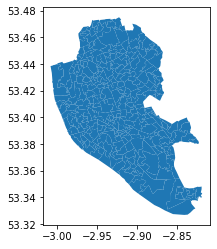

In [323]:
# Plot to check it looks like Liverpool
Liverpool_lsoa.plot()

In [324]:
# Merge the geojson with the multiple deprivation lsoa data [Perhaps a simpler way to do this]
Liverpool_lsoa=Liverpool_lsoa.merge(Liverpool_data, how='inner', on='LSOA code (2011)')

In [325]:
metrics=[
    'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 'Comparative illness and disability ratio indicator',
 'Acute morbidity indicator',
 'Mood and anxiety disorders indicator',
 'Road distance to a post office indicator (km)',
 'Road distance to a primary school indicator (km)',
 'Road distance to general store or supermarket indicator (km)',
 'Road distance to a GP surgery indicator (km)',
 'Household overcrowding indicator',
 'Homelessness indicator (rate per 1000 households)',
 'Owner-occupation affordability (component of housing affordability indicator)',
 'Private rental affordability (component of housing affordability indicator)',
 'Housing affordability indicator',
 'Housing in poor condition indicator',
 'Houses without central heating indicator',
 'Road traffic accidents indicator',
 'Nitrogen dioxide (component of air quality indicator)',
 'Benzene (component of air quality indicator)',
 'Sulphur dioxide (component of air quality indicator)',
 'Particulates (component of air quality indicator)',
 'Air quality indicator', 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)'
        ]

In [326]:
# Reads in the e-food deserts index data 

efdi_engwales=pd.read_csv("Data/efdi_england.csv")

In [327]:
efdi_engwales.head(n=5)

,LSOA or DZ,Nation,Score,Rank,Decile
0,W01000532,Wales,70.82672,1.0,1.0
1,W01000545,Wales,70.54694,2.0,1.0
2,W01000471,Wales,70.51910,3.0,1.0
3,W01000529,Wales,70.37505,4.0,1.0
4,W01000506,Wales,70.23811,5.0,1.0


In [328]:
#Merge with the lsoa data
Liverpool_lsoa=Liverpool_lsoa.merge(efdi_engwales, how='inner', left_on='LSOA code (2011)', right_on='LSOA or DZ')

<AxesSubplot:>

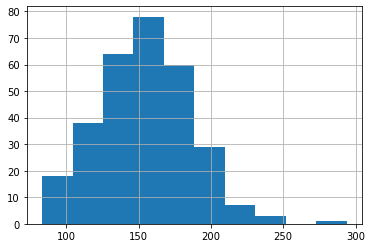

In [329]:
Liverpool_lsoa['Acute morbidity indicator'].hist()

In [330]:
metrics=metrics+['Score']

In [331]:
data_ranked=pd.DataFrame(Liverpool_lsoa["LSOA code (2011)"])

for measure in metrics:
# rank(pct=True), gives the percentile mul is multiply by 5
   new_col=pd.DataFrame(np.ceil(Liverpool_lsoa[measure].rank(pct=True).mul(5)).astype('Int64')).rename(columns={measure: measure+"_rank"})
   data_ranked=pd.concat([data_ranked, new_col], axis=1)

# Ranking is in the order i.e. the lowest scores will be in 1 and highest scores will be in 5

# Merges with the ranking data
Liverpool_lsoa=Liverpool_lsoa.merge(data_ranked, how='inner', left_on='LSOA code (2011)', right_on='LSOA code (2011)')

In [340]:
Liverpool_lsoa[['Income Domain numerator','Income Domain numerator_rank']]

,Income Domain numerator,Income Domain numerator_rank
0,195.0,2
1,110.0,1
2,465.0,4
3,495.0,4
4,685.0,5
...,...,...
293,1275.0,5
294,525.0,4
295,105.0,1
296,405.0,3


In [332]:
# Write out the food outlets location as a geojson for use in the mapbox map
Liverpool_lsoa.to_file("Data/Out/Liverpool_lsoa.geojson", driver='GeoJSON')

# Area data: Reads in the ward level data, adds in the geographies and write out as a geojson

In [131]:
# Import the ward level data 
food_poverty_stats=pd.read_csv("Data/Food_Poverty_Health_stats.csv")
food_poverty_stats.tail(n=5)

,WardCode,WardName,Year,Ward_DASR_Cancers_Under75,Liverpool_cancers_Under75,Ward_DASR_cvd_Under754,Liverpool_cvd_Under755,Ward_Reception_Overweight_Obese,Liverpool_Reception_Overweight_Obese,England_Reception_Overweight_Obese,Ward_Year6_Overweight_obese,Liverpool_Year6_Overweight_Obese,England_Year6_Overweight_Obese,Ward_alcohol_specific_admissions,Liverpool_alcohol_specific_admissions,England_alcohol_specific_admissions
150,E05000912,Wavertree,2020,185.505168,161.91919,89.562031,102.098598,26.0,26.8,23.0,27.9,41.5,35.2,700.5,1359.7,644.1
151,E05000913,West Derby,2020,104.307489,161.91919,68.388098,102.098598,20.6,26.8,23.0,35.1,41.5,35.2,793.7,1359.7,644.1
152,E05000914,Woolton,2020,67.342402,161.91919,44.288680,102.098598,22.2,26.8,23.0,26.4,41.5,35.2,597.7,1359.7,644.1
153,E05000915,Yew Tree,2020,142.877012,161.91919,67.773772,102.098598,31.0,26.8,23.0,35.8,41.5,35.2,1294.7,1359.7,644.1
154,E08000012,Liverpool,2020,161.919190,161.91919,102.098598,102.098598,26.8,26.8,23.0,41.5,41.5,35.2,1176.6,1359.7,644.1


In [132]:
# Subsets so we look just at 2020 data and drop the general all Liverpool data
food_poverty_stats2020=food_poverty_stats[(food_poverty_stats['Year']==2020) & (food_poverty_stats['WardName']!="Liverpool")]
food_poverty_stats2020.head(n=5)

,WardCode,WardName,Year,Ward_DASR_Cancers_Under75,Liverpool_cancers_Under75,Ward_DASR_cvd_Under754,Liverpool_cvd_Under755,Ward_Reception_Overweight_Obese,Liverpool_Reception_Overweight_Obese,England_Reception_Overweight_Obese,Ward_Year6_Overweight_obese,Liverpool_Year6_Overweight_Obese,England_Year6_Overweight_Obese,Ward_alcohol_specific_admissions,Liverpool_alcohol_specific_admissions,England_alcohol_specific_admissions
124,E05000886,Allerton and Hunts Cross,2020,161.265534,161.91919,87.231658,102.098598,21.6,26.8,23.0,36.9,41.5,35.2,700.9,1359.7,644.1
125,E05000887,Anfield,2020,197.133607,161.91919,173.637910,102.098598,31.2,26.8,23.0,39.4,41.5,35.2,1694.9,1359.7,644.1
126,E05000888,Belle Vale,2020,179.584437,161.91919,103.040845,102.098598,28.8,26.8,23.0,45.3,41.5,35.2,1063.1,1359.7,644.1
127,E05000889,Central,2020,100.539600,161.91919,129.607434,102.098598,25.0,26.8,23.0,48.9,41.5,35.2,983.6,1359.7,644.1
128,E05000890,Childwall,2020,111.995170,161.91919,65.638654,102.098598,26.5,26.8,23.0,30.7,41.5,35.2,470.4,1359.7,644.1


In [133]:
#Create a list of features to stick the different wards together into a single geojson
features = []


for ward in food_poverty_stats2020['WardCode']:
       boundary=get_shape(ward)
       # Extract the polygon coordinates from geojson
       polygon_boundary=boundary[0]["http://www.opengis.net/ont/geosparql#asWKT"][0]['@value']
       # Use shapely to load into the geometry
       features.append(Feature(geometry=shapely.wkt.loads(polygon_boundary),properties={"WardCode": ward }))
        
        
Liverpool_wards = FeatureCollection(features)


# Write it out as a geojson
with open('Data/Liverpool_wards.geojson', 'w') as f:
   dump(Liverpool_wards, f)

# write out as a geojson
filename = "Data/Liverpool_wards.geojson"
file = open(filename, encoding='latin1')

#and read back in
Liverpool_wards = gpd.read_file(file)




In [106]:
# Merge with the other ward data, seems simpler to do it this way, but maybe not
Liverpool_wards=Liverpool_wards.merge(food_poverty_stats2020, how='inner', on='WardCode')

In [107]:
list(Liverpool_wards)

['WardCode',
 'geometry',
 'WardName',
 'Year',
 'Ward_DASR_Cancers_Under75',
 'Liverpool_cancers_Under75',
 'Ward_DASR_cvd_Under754',
 'Liverpool_cvd_Under755',
 'Ward_Reception_Overweight_Obese',
 'Liverpool_Reception_Overweight_Obese',
 'England_Reception_Overweight_Obese',
 'Ward_Year6_Overweight_obese',
 'Liverpool_Year6_Overweight_Obese',
 'England_Year6_Overweight_Obese',
 'Ward_alcohol_specific_admissions',
 'Liverpool_alcohol_specific_admissions',
 'England_alcohol_specific_admissions']

In [177]:
measures=["Ward_DASR_Cancers_Under75","Ward_DASR_cvd_Under754" ,
          "Ward_Reception_Overweight_Obese", 
         "Ward_Year6_Overweight_obese" , 
          "Ward_alcohol_specific_admissions"]

In [178]:
wards_ranked=pd.DataFrame(food_poverty_stats2020["WardCode"])


# converts the variables into quintiles and then adds to the original Geodataframe (adding as a straight dataframe causes problems)
for measure in measures: 
    new_col=pd.DataFrame(np.ceil(food_poverty_stats2020[measure].rank(pct=True).mul(5)).astype('Int64')).rename(columns={measure: measure+"_rank"})
    wards_ranked=pd.concat([wards_ranked, new_col], axis=1)

In [179]:
# Merge with the other ward data, seems simpler to do it this way, but maybe not
Liverpool_wards=Liverpool_wards.merge(wards_ranked, on='WardCode')

In [180]:
Liverpool_wards.to_file("Data/Out/Liverpool_wards.geojson", driver='GeoJSON')

# Extracting the Liverpool border area file

In [233]:
features=[]

Liv=food_poverty_stats[(food_poverty_stats['WardName']=="Liverpool") & (food_poverty_stats['Year']==2020) ]
# Get the shape file for the Liverpool city code
boundary=get_shape("E08000012")

In [234]:
polygon_boundary=boundary[0]["http://www.opengis.net/ont/geosparql#asWKT"][0]['@value']
# Use shapely to load into the geometry
features.append(Feature(geometry=shapely.wkt.loads(polygon_boundary),properties={"WardCode": "E08000012" }))

In [235]:
Liverpool_boundary = FeatureCollection(features)

In [243]:
# Write it out as a geojson, note this may require reformatting to reload into mapbox
with open('Data/Out/Liverpool_boundary.geojson', 'w') as f:
    dump( Liverpool_boundary, f)
    
    
# Read in the geojson
filename = "Data/Out/Liverpool_boundary.geojson"
Liverpool_boundary = open(filename, encoding='latin1')

# and then read in (Writing out and reading in is wasteful, must be a better way)
Liverpool_boundary = gpd.read_file(Liverpool_boundary)

<AxesSubplot:>

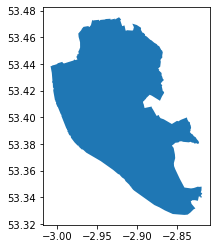

In [244]:
Liverpool_boundary.plot()

# Get a bounding box

This expands the bounding box around Liverpool so that the map border is wider than the area of the Liverpool shape file

In [245]:
Liverpool_boundary_expand=Liverpool_boundary

In [246]:
Liverpool_boundary.total_bounds

array([-3.008753, 53.326789, -2.818   , 53.474967])

In [247]:
Liverpool_boundary_expand.geometry.iloc[0] = shapely.affinity.scale(Liverpool_boundary_expand.geometry.iloc[0], xfact=1.6, yfact=1.6, origin='center')




In [248]:
Liverpool_boundary_expand.total_bounds

array([-3.0659789, 53.2823356, -2.7607741, 53.5194204])

# Points data: The geocoding function (to code the food outlets data and the food banks data)

In [16]:
# Initialises the geocoding
geolocator = Nominatim(user_agent="Liverpool_analysis")

In [17]:
# The geocoding function  x is the full address, y is the postcode as a back up if the address fails

def long_lat_func(x, y):
  try:
    location = geolocator.geocode(str(x))
    # Parse the tuple
    return location.latitude , location.longitude
  except:
    # Something causing an issue on the address, try on the postcode if it exists
   if y!="missing":
     try:
        location = geolocator.geocode(str(y))
        return location.latitude , location.longitude
     # Postcode geocode fails return nothing
     except:
      return None, None
  # If no postcode at all just return nothing
   else:
      return None, None

In [18]:
# Code to speed up the geocoding
'''


import multiprocessing from geopy.geocoders 
import Nominatim geocoder = Nominatim() 
def worker(address):
    return geocoder.geocode(address) 

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) 
addresses = ['58 Victoria Embankment, London', 'Ferry Road, Edinburgh'] l
ocations = pool.map(worker, addresses) '''

"\n\n\nimport multiprocessing from geopy.geocoders \nimport Nominatim geocoder = Nominatim() \ndef worker(address):\n    return geocoder.geocode(address) \n\npool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) \naddresses = ['58 Victoria Embankment, London', 'Ferry Road, Edinburgh'] l\nocations = pool.map(worker, addresses) "

# Points data: Geocoding the food outlets data 

In [19]:
# Example of the xml that is being parsed
'''
<Header>
    <ExtractDate>2021-01-27</ExtractDate>
    <ItemCount>3959</ItemCount>
    <ReturnCode>Success</ReturnCode>
  </Header>
  <EstablishmentCollection>
    <EstablishmentDetail>
      <FHRSID>1264123</FHRSID>
      <LocalAuthorityBusinessID>78306</LocalAuthorityBusinessID>
      <BusinessName>@Desserts</BusinessName>
      <BusinessType>Takeaway/sandwich shop</BusinessType>
      <BusinessTypeID>7844</BusinessTypeID>
      <AddressLine1>17, Central Shopping Centre Ranelagh Street</AddressLine1>
      <AddressLine3>Liverpool</AddressLine3>
      <AddressLine4>Liverpool</AddressLine4>
      <PostCode>L1 1QE</PostCode>
      <RatingValue>AwaitingInspection</RatingValue>
      <RatingKey>fhrs_awaitinginspection_en-GB</RatingKey>
      <RatingDate xsi:nil="true"/>
      <LocalAuthorityCode>414</LocalAuthorityCode>
      <LocalAuthorityName>Liverpool</LocalAuthorityName>
      <LocalAuthorityWebSite>http://www.liverpool.gov.uk</LocalAuthorityWebSite>
      <LocalAuthorityEmailAddress>environmental.health@liverpool.gov.uk</LocalAuthorityEmailAddress>
      <Scores/>
      <SchemeType>FHRS</SchemeType>
      <NewRatingPending>False</NewRatingPending>
      <Geocode>
      
      '''

'\n<Header>\n    <ExtractDate>2021-01-27</ExtractDate>\n    <ItemCount>3959</ItemCount>\n    <ReturnCode>Success</ReturnCode>\n  </Header>\n  <EstablishmentCollection>\n    <EstablishmentDetail>\n      <FHRSID>1264123</FHRSID>\n      <LocalAuthorityBusinessID>78306</LocalAuthorityBusinessID>\n      <BusinessName>@Desserts</BusinessName>\n      <BusinessType>Takeaway/sandwich shop</BusinessType>\n      <BusinessTypeID>7844</BusinessTypeID>\n      <AddressLine1>17, Central Shopping Centre Ranelagh Street</AddressLine1>\n      <AddressLine3>Liverpool</AddressLine3>\n      <AddressLine4>Liverpool</AddressLine4>\n      <PostCode>L1 1QE</PostCode>\n      <RatingValue>AwaitingInspection</RatingValue>\n      <RatingKey>fhrs_awaitinginspection_en-GB</RatingKey>\n      <RatingDate xsi:nil="true"/>\n      <LocalAuthorityCode>414</LocalAuthorityCode>\n      <LocalAuthorityName>Liverpool</LocalAuthorityName>\n      <LocalAuthorityWebSite>http://www.liverpool.gov.uk</LocalAuthorityWebSite>\n      <L

In [20]:
tree = ET.parse('Data/Liverpool_food_outlets.xml')
root = tree.getroot()



df_cols = ["LocalAuthorityBusinessID", "BusinessName","BusinessAddress","BusinessType","BusinessTypeID", "RatingKey", "Postcode"]
rows = []

food_outlets_df  = pd.DataFrame(rows, columns = df_cols)

# Tidy up the parsing if time to much hacked together from Stackoverflow
for neighbor in root.iter('EstablishmentCollection'):
   for node in neighbor:
       bus_laid=node.find("LocalAuthorityBusinessID").text  if node is not None else None
       bus_rate=node.find("RatingKey").text if node is not None else None  
       bus_address=""
       try:
        bus_address=bus_address+" "+node.find('AddressLine1').text 
       except:
        bus_address=bus_address     
       try:
        bus_address=bus_address+" "+node.find('AddressLine2').text 
       except:
        bus_address=bus_address 
       try:
        bus_address=bus_address+" "+node.find('AddressLine3').text 
       except:
        bus_address=bus_address
       try:
         bus_postcode=node.find("PostCode").text if node is not None else None
         bus_address=bus_address+" "+bus_postcode+ " "+"UK" 
       except:
          bus_postcode=("missing")    
       bus_type=node.find("BusinessType").text if node is not None else None
       bus_name=node.find("BusinessName").text  if node is not None else None
       bus_type_id=node.find("BusinessTypeID").text if node is not None else None
       try:
         bus_postcode=node.find("PostCode").text if node is not None else None
       except:
          bus_postcode=("missing") 
       rows.append({"LocalAuthorityBusinessID": bus_laid, "BusinessName": bus_name, "BusinessAddress": bus_address,
                  "BusinessType": bus_type,"BusinessTypeID":bus_type_id, "Postcode": bus_postcode, "RatingValue": bus_rate})

food_outlets_df = pd.DataFrame(rows, columns = df_cols)

food_outlets_df.head(n=5)

,LocalAuthorityBusinessID,BusinessName,BusinessAddress,BusinessType,BusinessTypeID,RatingKey,Postcode
0,78306,@Desserts,"17, Central Shopping Centre Ranelagh Street L...",Takeaway/sandwich shop,7844,NaN,L1 1QE
1,71900,08 Burger Unit,,Mobile caterer,7846,NaN,missing
2,79155,109 Allerton,109 Allerton Road Mossley Hill Liverpool L18 ...,Restaurant/Cafe/Canteen,1,NaN,L18 2DD
3,78939,14forty,100 Wavertree Boulevard Liverpool L7 9PT UK,Restaurant/Cafe/Canteen,1,NaN,L7 9PT
4,PI/000272350,2 in 1,54 Durning Road Liverpool L7 5NG UK,Takeaway/sandwich shop,7844,NaN,L7 5NG


In [21]:
pd.DataFrame(food_outlets_df["BusinessType"].value_counts())

,BusinessType
Restaurant/Cafe/Canteen,1152
Retailers - other,741
Takeaway/sandwich shop,685
Pub/bar/nightclub,388
Other catering premises,229
Hospitals/Childcare/Caring Premises,198
School/college/university,186
Retailers - supermarkets/hypermarkets,124
Mobile caterer,117
Hotel/bed & breakfast/guest house,87


In [22]:
# Functions to tidy up the address information that is proving hard to geocode

# Remove text before the first comma as this seems typically to be the name of the business which is throwing the geocoder
def trim_name(x):
    return re.sub(r'^.*?,', '',x)

# Remove text before supermarket (case insensitive) as this is typically the name of a supermarket
def trim_supermarket(x):
    return re.sub(r'^.*?supermarket', '',x, flags=re.IGNORECASE)

In [23]:

# Strips the text before the column as this seems to almost always be a name that is throwing the geocoding
food_outlets_df["BusinessAddress_clean"]=food_outlets_df["BusinessAddress"].apply(lambda x: trim_name(x))
# Remove the text that appears before the word supermarket as this also seems to call
food_outlets_df["BusinessAddress_clean"]=food_outlets_df["BusinessAddress_clean"].apply(lambda x:trim_supermarket(x))

# Create a new postcode variable that makes it clear we are talking about Liverpool in the UK to avoid confusing geocoder
food_outlets_df["Postcode_clean"]=np.where(food_outlets_df["Postcode"]!="missing",food_outlets_df["Postcode"]+", Liverpool, UK"
                                           , food_outlets_df["Postcode"])

In [24]:

# Applies the geocoding function takes about 40 minutes uses the cleaned business address with the postcode as a backup

start_time = time()
food_outlets_df["lat"] , food_outlets_df["lon"] = zip(*food_outlets_df.apply(lambda x: long_lat_func(x["BusinessAddress_clean"], x["Postcode_clean"]), axis=1))

time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 41.61 minutes ---


In [25]:
food_outlets_df.head(n=5)

,LocalAuthorityBusinessID,BusinessName,BusinessAddress,BusinessType,BusinessTypeID,RatingKey,Postcode,BusinessAddress_clean,Postcode_clean,lat,lon
0,78306,@Desserts,"17, Central Shopping Centre Ranelagh Street L...",Takeaway/sandwich shop,7844,NaN,L1 1QE,Central Shopping Centre Ranelagh Street Liver...,"L1 1QE, Liverpool, UK",53.404688,-2.979993
1,71900,08 Burger Unit,,Mobile caterer,7846,NaN,missing,,missing,None,None
2,79155,109 Allerton,109 Allerton Road Mossley Hill Liverpool L18 ...,Restaurant/Cafe/Canteen,1,NaN,L18 2DD,109 Allerton Road Mossley Hill Liverpool L18 ...,"L18 2DD, Liverpool, UK",53.381847,-2.905478
3,78939,14forty,100 Wavertree Boulevard Liverpool L7 9PT UK,Restaurant/Cafe/Canteen,1,NaN,L7 9PT,100 Wavertree Boulevard Liverpool L7 9PT UK,"L7 9PT, Liverpool, UK",53.405729,-2.934059
4,PI/000272350,2 in 1,54 Durning Road Liverpool L7 5NG UK,Takeaway/sandwich shop,7844,NaN,L7 5NG,54 Durning Road Liverpool L7 5NG UK,"L7 5NG, Liverpool, UK",53.406444,-2.948425


In [26]:
# Subsets to drop the na terms
food_outlets_df_clean=food_outlets_df.dropna(subset=['lon', 'lat'])


#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(food_outlets_df_clean['lon'], food_outlets_df_clean['lat'])]


# Create a GeoDataFrame from the food_outlets
food_outlets_geo = gpd.GeoDataFrame(food_outlets_df_clean, crs = 'epsg:4326' , geometry = geometry)


# Select the food outlets that fall within Liverpool lsoas
food_outlets_geo = gpd.overlay(food_outlets_geo , Liverpool_boundary, how='intersection')

# Split out supermarkets as it makes it easier to handle them

# Split out the supermarkets
supermarkets =food_outlets_geo[food_outlets_geo["BusinessType"]=='Retailers - supermarkets/hypermarkets']
                                                          
# Other food outlets
food_outlets_geo=food_outlets_geo[food_outlets_geo["BusinessType"]!='Retailers - supermarkets/hypermarkets']

<AxesSubplot:>

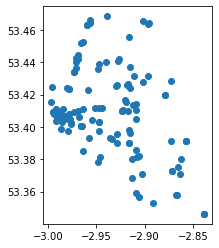

In [27]:
supermarkets.plot()

In [28]:
supermarkets

,LocalAuthorityBusinessID,BusinessName,BusinessAddress,BusinessType,BusinessTypeID,RatingKey,Postcode,BusinessAddress_clean,Postcode_clean,lat,...,Housing in poor condition indicator_rank,Houses without central heating indicator_rank,Road traffic accidents indicator_rank,Nitrogen dioxide (component of air quality indicator)_rank,Benzene (component of air quality indicator)_rank,Sulphur dioxide (component of air quality indicator)_rank,Particulates (component of air quality indicator)_rank,Air quality indicator_rank,Score_rank,geometry
148,PI/000212829,Sainsbury's,"Sainsburys Local Supermarket, 8, Central Shop...",Retailers - supermarkets/hypermarkets,7840,NaN,L1 1QE,"8, Central Shopping Centre Ranelagh Street Li...","L1 1QE, Liverpool, UK",53.404618,...,4,2,3,3,1,4,3,2,1,POINT (-2.97986 53.40462)
163,PI/000236330,Tesco,"Tesco Supermarket, 46 Hanover Street Liverpoo...",Retailers - supermarkets/hypermarkets,7840,NaN,L1 4AA,46 Hanover Street Liverpool L1 4AA UK,"L1 4AA, Liverpool, UK",53.402786,...,4,2,3,3,1,4,3,2,1,POINT (-2.98538 53.40279)
232,76096,Tesco Express,"Tesco Express Supermarket, 5 Allerton Road Mo...",Retailers - supermarkets/hypermarkets,7840,NaN,L18 1LG,5 Allerton Road Mossley Hill Liverpool L18 1L...,"L18 1LG, Liverpool, UK",53.381847,...,4,1,3,3,1,2,3,1,1,POINT (-2.90548 53.38185)
251,71641,Iceland,2 Prescot Road Fairfield Liverpool L7 0LQ UK,Retailers - supermarkets/hypermarkets,7840,NaN,L7 0LQ,2 Prescot Road Fairfield Liverpool L7 0LQ UK,"L7 0LQ, Liverpool, UK",53.411997,...,3,5,3,3,3,5,3,4,4,POINT (-2.94376 53.41200)
261,PI/000273711,Jacks (Tesco),"Jacks, 10 Overton Street Liverpool L7 3HE UK",Retailers - supermarkets/hypermarkets,7840,NaN,L7 3HE,10 Overton Street Liverpool L7 3HE UK,"L7 3HE, Liverpool, UK",53.404192,...,1,2,3,3,3,5,3,5,5,POINT (-2.95431 53.40419)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,PI/000260082,Tesco Stores Limited,22 - 26 Finch Road Liverpool L14 4AT UK,Retailers - supermarkets/hypermarkets,7840,NaN,L14 4AT,22 - 26 Finch Road Liverpool L14 4AT UK,"L14 4AT, Liverpool, UK",53.428577,...,3,1,3,3,3,2,3,3,4,POINT (-2.87242 53.42858)
3662,PI/000175322,Sainsbury's,"Sainsburys Supermarket, 1, Sainsburys Centre ...",Retailers - supermarkets/hypermarkets,7840,NaN,L25 5QA,"1, Sainsburys Centre James Road Liverpool L25...","L25 5QA, Liverpool, UK",53.375538,...,1,3,3,3,2,1,3,1,2,POINT (-2.86550 53.37554)
3706,PI/000241103,Jack's,"Tesco Metro Supermarket, 124 County Road Live...",Retailers - supermarkets/hypermarkets,7840,NaN,L4 3QW,124 County Road Liverpool L4 3QW UK,"L4 3QW, Liverpool, UK",53.441996,...,5,5,3,3,5,5,3,5,5,POINT (-2.96948 53.44200)
3723,PI/000270668,McColls,"Co Operative Food Supermarket, 7 - 8, The Par...",Retailers - supermarkets/hypermarkets,7840,NaN,L15 7JU,"7 - 8, The Parade Northway Liverpool L15 7JU UK","L15 7JU, Liverpool, UK",53.404885,...,2,2,3,3,4,5,3,5,4,POINT (-2.90881 53.40489)


<AxesSubplot:>

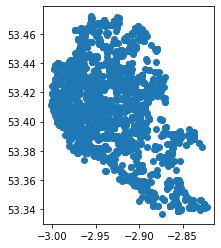

In [29]:
food_outlets_geo.plot()

In [30]:
# Write out the food outlets location as a geojson for use in the mapbox map
food_outlets_geo.to_file("Data/Out/Food_outlets_geo.geojson", driver='GeoJSON')

# Write out the supermarkets
supermarkets.to_file("Data/Out/Supermarkets_geo.geojson", driver='GeoJSON')

# Points data: Geocoding the affordable food initatives 

In [31]:
ls Data/

 Affordable_food_inititives_Liverpool.xlsx
 Food_Poverty_Health_stats.csv
 Food_outlets_geo.geojson
 Foodbanks.geojson
 Liverpool_food_outlets.xml
 Liverpool_foodbanks_geocode_input.csv
 Liverpool_lsoa.geojson
 Out/
 efdi_england.csv
 emergency_food_providers.xlsx
 map_data_processing
'~$Affordable_food_inititives_Liverpool.xlsx'
'~$emergency_food_providers.xlsx'


In [32]:
!pip3 install openpyxl

     |████████████████████████████████| 243 kB 9.8 MB/s eta 0:00:01


In [33]:
Affordable_food_sheet = pd.ExcelFile('Data/Affordable_food_initatives_Liverpool.xlsx')

In [34]:
Affordable_food_sheet.sheet_names

['Pantrys, Com markets, Com Shops',
 'Community cafes ',
 'Free food inititives ']

In [35]:
Pantrys=pd.read_excel(Affordable_food_sheet, 'Pantrys, Com markets, Com Shops')
Pantrys=Pantrys.iloc[0:27] # avoid the numbers that has slipped down the sheet
Pantrys=Pantrys.rename(columns=lambda x: x.strip())

Community_cafes=pd.read_excel(Affordable_food_sheet, 'Community cafes ')
Community_cafes=Community_cafes.dropna(how='all')
Community_cafes=Community_cafes.rename(columns=lambda x: x.strip())

Free_food_inititives=pd.read_excel(Affordable_food_sheet, 'Free food inititives ')
Free_food_inititives=Free_food_inititives.dropna(how='all')
Free_food_inititives=Free_food_inititives.rename(columns=lambda x: x.strip())

Pantrys['Category']='Pantry'
Community_cafes['Category']='Community_cafes'
Free_food_inititives['Category']='Free_food_inititives'

Affordable_food_outlets_df = pd.concat([Pantrys,Community_cafes,Free_food_inititives] , ignore_index=True)

In [36]:
 Affordable_food_outlets_df=Affordable_food_outlets_df.rename(columns=lambda x: x.strip())

In [37]:
list(Affordable_food_outlets_df)

['Name',
 'Affiliated organisation',
 'Address',
 'Postcode',
 'Day',
 'Time',
 'Membership model?',
 'Cost',
 'Geographical area',
 'Website',
 'EMAIL',
 'TWITTER',
 'FACEBOOK',
 'Contact phone',
 'Main contact person (private)',
 'Notes',
 'Unnamed: 16',
 'Category',
 'Contact details (publically avaibale) EMAIL',
 'Contact details (publically avaibale) TWITTER',
 'Contact details (publically avaibale) FACEBOOK',
 'Contact phone (publically available / permission given)',
 'Main contact (private)',
 'Covid 19 status (open/closed)']

In [38]:
Affordable_food_outlets_df['Addresses']=Affordable_food_outlets_df['Address']+" "+Affordable_food_outlets_df["Postcode"]+" "+"Liverpool UK"

In [39]:
Affordable_food_outlets_df['Category'].value_counts()

Pantry                  27
Free_food_inititives    14
Community_cafes          6
Name: Category, dtype: int64

In [40]:
Affordable_food_outlets_df[Affordable_food_outlets_df['Category']=="Pantry"]

,Name,Affiliated organisation,Address,Postcode,Day,Time,Membership model?,Cost,Geographical area,Website,...,Notes,Unnamed: 16,Category,Contact details (publically avaibale) EMAIL,Contact details (publically avaibale) TWITTER,Contact details (publically avaibale) FACEBOOK,Contact phone (publically available / permission given),Main contact (private),Covid 19 status (open/closed),Addresses
0,St George's Pantry,St Andrews Community Network Your Local Pantry,"St George's Church, Heyworth Street",L5 3QG,Friday,08:45 - 11:00,Yes,3.5,Everton Ward or a child attending Beacon CE Pr...,https://www.yourlocalpantry.co.uk/find-a-pantr...,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"St George's Church, Heyworth Street L5 3QG Li..."
1,Christ Church Pantry,St Andrews Community Network Your Local Pantry,"Sedgemoor Road, Liverpool",L11 3BR,Tuesday,13:00 - 15:00,Yes,3.5,NaN,https://www.yourlocalpantry.co.uk/find-a-pantr...,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Sedgemoor Road, Liverpool L11 3BR Liverpool UK"
2,St Andrews Pantry,St Andrews Community Network Your Local Pantry,"Adshead Road Entrance, Clubmoor",L13 0AL,Wednesday,09:00 - 17:00,Yes,3.5,NaN,https://www.yourlocalpantry.co.uk/find-a-pantr...,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Adshead Road Entrance, Clubmoor L13 0AL Liverp..."
3,L6 Food Union,L6 Centre,"99 Queens Road, Everton, Liverpool",L6 2NF,Monday - Thursday,"(Mon)12:00 - 15:00(Tue,Wed,Thurs)10:00 - 15:30",Yes,"15 items £7.50 , 20 items £10.00 or 30 items £...",Anyone during covid-19 crisis,https://liverpool6community.wixsite.com/website,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"99 Queens Road, Everton, Liverpool L6 2NF Live..."
4,HOPE pantry,Our House Walton,"15 Heathcote Road, Walton, Liverpool",L4 6XB,NaN,NaN,Yes,"10 Items - £3.50 per week, 15 Items - £5.00 pe...",NaN,https://ourhouse-walton.co.uk/hope-pantry,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"15 Heathcote Road, Walton, Liverpool L4 6XB Li..."
5,The Florrie Food Union,The Florrie,"377 Mill Street, Liverpool",L8 4RF,NaN,NaN,Yes,3.5,NaN,https://www.theflorrie.org/our-projects/foodun...,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"377 Mill Street, Liverpool L8 4RF Liverpool UK"
6,Walton Vale Community Shop,Fazakerley Labour councillors,"Perfect Homes Shop, 105 Walton Vale, Liverpool",L9 4SR,Tuesday,12:30 - 14:30,Yes,3.5,People who live in L9,https://www.thelivewelldirectory.com/Services/493,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Perfect Homes Shop, 105 Walton Vale, Liverpool..."
7,Croxteth Community Family Matters Food Pantry,The Big Help Project,"Mossway Hall, 35 Moss Way, Liverpool",L11 0BL,Thursday and Friday,(booking slots only)(thurs)09:00 - 16:00(Fri)0...,Yes,3,Croxteth,http://www.croxtethfamilymatters.co.uk/food-pa...,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Mossway Hall, 35 Moss Way, Liverpool L11 0BL L..."
8,Epsom Street Community Market,Nugent Care,"Epsom Street Centre, Goodwood Street, Liverpool",L5 2QT,Tuesday,From 10:00,No,5,NaN,https://www.wearenugent.org/service/epsy/,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Epsom Street Centre, Goodwood Street, Liverpoo..."
9,Dovecot Community Food Partnership Food Pantry,Alt Valley,"Dovecot Multi Activity Centre (MAC), 10 Back D...",L14 9BA,Monday,12:30 - 14:30,Yes,3.5,NaN,https://www.altvalley.co.uk/,...,NaN,NaN,Pantry,NaN,NaN,NaN,NaN,NaN,NaN,"Dovecot Multi Activity Centre (MAC), 10 Back D..."


In [41]:
list(Affordable_food_outlets_df)

['Name',
 'Affiliated organisation',
 'Address',
 'Postcode',
 'Day',
 'Time',
 'Membership model?',
 'Cost',
 'Geographical area',
 'Website',
 'EMAIL',
 'TWITTER',
 'FACEBOOK',
 'Contact phone',
 'Main contact person (private)',
 'Notes',
 'Unnamed: 16',
 'Category',
 'Contact details (publically avaibale) EMAIL',
 'Contact details (publically avaibale) TWITTER',
 'Contact details (publically avaibale) FACEBOOK',
 'Contact phone (publically available / permission given)',
 'Main contact (private)',
 'Covid 19 status (open/closed)',
 'Addresses']

In [42]:
# Applies the geocoding function

start_time = time()


Affordable_food_outlets_df["lat"] , Affordable_food_outlets_df["lon"] = zip(*Affordable_food_outlets_df.apply(lambda x: long_lat_func(x["Addresses"],x["Postcode"]) , axis=1))

time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 0.56 minutes ---


In [43]:
# Subsets to drop the na terms
Affordable_food_outlets_df_clean=Affordable_food_outlets_df.dropna(subset=['lon', 'lat'])
Affordable_food_outlets_df_clean=Affordable_food_outlets_df_clean.dropna(subset=['Name'])
Affordable_food_outlets_df_clean=Affordable_food_outlets_df_clean.dropna(subset=['Address'])

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(Affordable_food_outlets_df_clean['lon'], Affordable_food_outlets_df_clean['lat'])]



# Create a GeoDataFrame from art and verify the type
Affordable_food_outlets = gpd.GeoDataFrame(Affordable_food_outlets_df_clean, crs = 'epsg:4326' , geometry = geometry)

In [48]:
Affordable_food_outlets["Time"]=str(Affordable_food_outlets["Time"])

<AxesSubplot:>

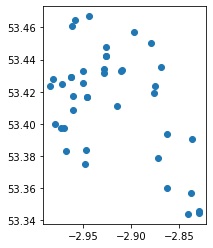

In [49]:
Affordable_food_outlets.plot()

In [50]:
# Write out the food initatives location as a geojson for use in the mapbox map
Affordable_food_outlets.to_file("Data/Out/Affordable_food_iniatives.geojson", driver='GeoJSON')

# Points data: Geocoding the Emergency food initatives

In [51]:
Emergency_food_sheet = pd.ExcelFile('Data/emergency_food_providers.xlsx')

In [52]:
Emergency_food_sheet.sheet_names

['Sheet1', 'Sheet2']

In [53]:
Food_parcel=pd.read_excel(Emergency_food_sheet, 'Sheet1')
Food_parcel=Food_parcel.dropna(how='all')
Food_parcel=Food_parcel.rename(columns=lambda x: x.strip())
Food_parcel=Food_parcel.rename(columns={'Emergency food parcel provider':'Name'})

Meal_providers=pd.read_excel(Emergency_food_sheet, 'Sheet2')
Meal_providers=Meal_providers.dropna(how='all')
Meal_providers=Meal_providers.rename(columns=lambda x: x.strip())
Meal_providers=Meal_providers.rename(columns={'Emergency meal provider':'Name'})


Food_parcel['Category']='Food_parcels'
Meal_providers['Category']='Meal_providers'


Emergency_food_suppliers = pd.concat([Food_parcel,Meal_providers] , ignore_index=True)

In [54]:
Emergency_food_suppliers['Category'].value_counts() 

Food_parcels      43
Meal_providers    19
Name: Category, dtype: int64

In [55]:
Emergency_food_suppliers['Addresses']=Emergency_food_suppliers['Address']+" "+Emergency_food_suppliers["Postcode"]+" "+" UK"

In [56]:
# Drop the mobile food suppliers
Emergency_food_suppliers=Emergency_food_suppliers[Emergency_food_suppliers['Address']!="Mobile "]

start_time = time()

Emergency_food_suppliers["lat"] , Emergency_food_suppliers["lon"] = zip(*Emergency_food_suppliers.apply(lambda x: long_lat_func(x["Addresses"],x["Postcode"]) , axis=1))
time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 0.76 minutes ---


In [57]:
# Subsets to drop the na terms for the locations
Emergency_food_suppliers_clean=Emergency_food_suppliers.dropna(subset=['lon', 'lat'])

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(Emergency_food_suppliers_clean['lon'], Emergency_food_suppliers_clean['lat'])]



# Create a GeoDataFrame from the data
Emergency_food_suppliers= gpd.GeoDataFrame(Emergency_food_suppliers_clean, crs = 'epsg:4326' , geometry = geometry)

In [58]:
Emergency_food_suppliers_clean

,Name,Address,Postcode,Category,Addresses,lat,lon,geometry
0,Deysbrook Village Centre,"Deysbrook Way, Liverpool",L12 4XF,Food_parcels,"Deysbrook Way, Liverpool L12 4XF UK",53.435818,-2.893066,POINT (-2.89307 53.43582)
1,Alive Believers Centre,"259-261 Boaler Street, Liverpool",L6 9DH,Food_parcels,"259-261 Boaler Street, Liverpool L6 9DH UK",53.416254,-2.951455,POINT (-2.95146 53.41625)
2,All Saints Liverpool,"55 Sheil Road, Liverpool",L6 3AD,Food_parcels,"55 Sheil Road, Liverpool L6 3AD UK",53.416636,-2.946007,POINT (-2.94601 53.41664)
4,Torus Foundation,"FireFit Hub, 115 Upper Warwick Street",L8 8HD,Food_parcels,"FireFit Hub, 115 Upper Warwick Street L8 8HD UK",53.39236,-2.966368,POINT (-2.96637 53.39236)
5,Liverpool Homeless Football Club,"151 Dale Street, Liverpool",L2 2AH,Food_parcels,"151 Dale Street, Liverpool L2 2AH UK",53.410141,-2.983769,POINT (-2.98377 53.41014)
6,Rotunda Ltd,"107 -115 Great Mersey Street, Kirkdale, Liverpool",L5 2PL,Food_parcels,"107 -115 Great Mersey Street, Kirkdale, Liverp...",53.427944,-2.981408,POINT (-2.98141 53.42794)
7,Merseyside Jewish Community Care,"Shifrin House, 433 Smithdown Road, Liverpool",L15 3JL,Food_parcels,"Shifrin House, 433 Smithdown Road, Liverpool L...",53.390387,-2.929596,POINT (-2.92960 53.39039)
8,SOLA ARTS,"Toxteth Town Hall, 15 High Park Street, Liverpool",L8 8DX,Food_parcels,"Toxteth Town Hall, 15 High Park Street, Liverp...",53.386059,-2.964807,POINT (-2.96481 53.38606)
9,Felicity Food Bank,"Sandown Lane, Wavertree, Liverpool",L15 8HY,Food_parcels,"Sandown Lane, Wavertree, Liverpool L15 8HY UK",53.400876,-2.921477,POINT (-2.92148 53.40088)
10,Pakistan Association PAL,"168 Mulgrave Street, Liverpool",L8 2TF,Food_parcels,"168 Mulgrave Street, Liverpool L8 2TF UK",53.394276,-2.96004,POINT (-2.96004 53.39428)


<AxesSubplot:>

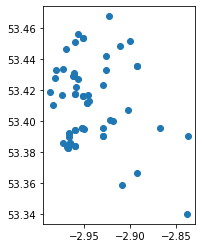

In [59]:
Emergency_food_suppliers.plot()

In [60]:
Emergency_food_suppliers.to_file("Data/Out/Emergency_food_suppliers.geojson", driver='GeoJSON')

In [ ]:
Emergency_food_suppliers["categ"]

# Generate a whole set of density plots

In [80]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt



proj = gcrs.AlbersEqualArea(central_latitude=53.40938, central_longitude=-2.92413)  
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection=proj)
#ax2 = plt.subplot(122, projection=proj)

gplt.kdeplot(supermarkets,
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax1
)
#gplt.polyplot(Liverpool_boundary, zorder=1, ax=ax1)
ax1.set_title("Supermarkets")

ModuleNotFoundError: No module named 'geoplot'

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=53.40938, central_longitude=-2.92413)  
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection=proj)
#ax2 = plt.subplot(122, projection=proj)

gplt.kdeplot(food_outlets_geo[food_outlets_geo["BusinessType"]=='Takeaway/sandwich shop'],
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax1
)
ax1.set_title("Takeaway/sandwich shop")

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=53.40938, central_longitude=-2.92413)  
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj) 
ax3 = plt.subplot(213, projection=proj)
ax3 = plt.subplot(224, projection=proj) 

gplt.kdeplot(food_outlets_geo[food_outlets_geo["BusinessType"]=='Restaurant/Cafe/Canteen'],
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax1
)

ax1.set_title('Restaurant/Cafe/Canteen')



gplt.kdeplot(food_outlets_geo[food_outlets_geo["BusinessType"]=='Pub/bar/nightclub'],
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax2
)

ax2.set_title('Pub bar nightclub')


gplt.kdeplot(supermarkets,
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax3
)
#gplt.polyplot(Liverpool_boundary, zorder=1, ax=ax1)
ax3.set_title("Supermarkets")


gplt.kdeplot(Emergency_food_suppliers[Emergency_food_suppliers["Category"]=="Meal_providers"] ,
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax4
)
#gplt.polyplot(Liverpool_boundary, zorder=1, ax=ax1)
ax4.set_title("Meal providers")


In [ ]:
Emergency_food_suppliers[Emergency_food_suppliers["Category"]=="Food_parcels"] 

proj = gcrs.AlbersEqualArea(central_latitude=53.40938, central_longitude=-2.92413)  
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection=proj)
#  "Food_parcels"
gplt.kdeplot(Emergency_food_suppliers[Emergency_food_suppliers["Category"]=="Meal_providers"]  ,
    cmap='Reds',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=Liverpool_wards.geometry,
    ax=ax1
)

In [ ]:
Pantry                  27
Free_food_inititives    14
Community_cafes  

In [ ]:
# Check that everything has been written out
! ls Data

In [ ]:
pwd

In [ ]:
ls